<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/Homework/5_Class_Homework/NL_Class5_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive')
TWSM_path = "/content/drive/MyDrive/teaching/TWSM/"

#from TWSM import *
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import spacy
## Import packages
import pickle
import pandas as pd
from gensim.models import Word2Vec
import time
import numpy as np
# run this from a normal command line
#!python -m spacy download en_core_web_md #160MB

#can I download this to a local file instead and load it fom drive?


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMD Movie Reviews**

In [6]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


#### Tasks

1. Train a word2vec model of dimension $100$ on the IMD data. (considering words appearing in more than 50 documents) Save the model if you like.

2. Compute the embedding for each review (average word2vec)

3. Fit a keras classifier to the embedded reviews. (2 hidden layers of size 40 each) Report/Monitor the accuracy on the test data.

4. Load the bing sentiment dictionary. Compute two separate embeddings for the negative and positive sentiments.

5. Compute the similarity between these two vectors and a few selected reviews. Does it agree with their label?


-------------------------------------------
## Solution

1. Train a word2vec model of dimension  100  on the IMD data. (considering words appearing in more than 50 documents) Save the model if you like.

**Decoding reviews back to text**

In [7]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review

1654784/1641221 [==============================] - 0s 0us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [8]:
N=len(train_data)
decoded_reviews = ["" for x in range(N)]

for j in range(N):
  decoded_reviews[j] = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[j]])

In [9]:
decoded_reviews[1]

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [10]:
df = pd.DataFrame(decoded_reviews,columns=['reviews'])
df.head()

,reviews
0,? this film was just brilliant casting locatio...
1,? big hair big boobs bad music and a giant saf...
2,? this has to be one of the worst films of the...
3,? the ? ? at storytelling the traditional sort...
4,? worst mistake of my life br br i picked this...


**Train the model**

In [11]:
corpus_gen = [text.split() for text in df['reviews']]

In [12]:
#Initiate the model
model = Word2Vec(corpus_gen,size = 100, min_count=50)

2. Compute the embedding for each review (average word2vec)

In [13]:
# Document representation for the text
corpus_w2v=[[model.wv[word] for word in doc if word in model.wv.vocab.keys()] for doc in corpus_gen]
positive=[i for i in range(len(corpus_gen)) if len(corpus_w2v[i])>0]

corpus_w2v2=[corpus_w2v[i] for i in positive]
data_lemma2=[df.reviews[i] for i in positive]

# Document average representation
corpus_w2v_avg_clean=[sum(words)/len(words) for words in corpus_w2v2]

# This corpus can be used later in clustering and classification tasks
print(corpus_w2v_avg_clean[10])

[-0.03405202 -0.15662953 -0.02236437  0.6443631  -0.13848172 -0.17724578
 -0.05760726 -0.17105941 -0.3747898  -0.19942641  0.3064822  -0.05263308
  0.18022044 -0.3508583   0.15298763  0.01380139 -0.295493    0.27011645
 -0.09051143 -0.40311655 -0.09200626 -0.26138538 -0.1923557   0.01600832
  0.02810809 -0.1482759  -0.3541117   0.74817777  0.22409213  0.08380935
 -0.14258353 -0.12551935  0.376635   -0.1383863   0.1639798   0.15425448
  0.06767736  0.15020958 -0.48097894 -0.3186854   0.4179286   0.2550667
  0.17380016  0.19582626  0.1246158   0.2675646   0.33269504  0.09317595
 -0.12935054  0.12238792 -0.0418225  -0.21427707  0.19506682 -0.2132442
  0.11422801 -0.24440795  0.20670108 -0.02957723  0.01440286 -0.06458332
  0.3310055  -0.21243177 -0.02502116 -0.1766697  -0.01470879  0.02813401
 -0.01378715 -0.3658029  -0.0077185  -0.09288549  0.41806373 -0.02076897
  0.10034382  0.02984751  0.36558113 -0.09589522 -0.3793331   0.34836742
 -0.07467314  0.07759359 -0.07055757  0.02161236  0.1

3. Fit a keras classifier to the embedded reviews. (2 hidden layers of size 40 each) Report/Monitor the accuracy on the test data.

In [14]:
# Model configuration
loss_function = 'binary_crossentropy'
optimizer = 'adam'
additional_metrics = ['accuracy']
number_of_epochs = 100
verbosity_mode = 1
validation_split = 0.30
input_dim = 100
batch_size = 64

In [15]:
model_clf = Sequential()
model_clf.add(Dense(40, input_dim = 100, activation='relu'))
model_clf.add(Dense(40, activation='relu'))
model_clf.add(Dense(1, activation='sigmoid'))
callback = EarlyStopping(monitor='accuracy', patience=15, mode = 'auto')

In [16]:
# Compile the model
model_clf.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)


In [17]:
# Train the model
history = model_clf.fit(np.array(corpus_w2v_avg_clean), train_labels, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split, callbacks = callback, batch_size = batch_size)

Epoch 1/100
274/274 [==============================] - 2s 4ms/step - loss: 0.4879 - accuracy: 0.7736 - val_loss: 0.4043 - val_accuracy: 0.8167
Epoch 2/100
274/274 [==============================] - 1s 4ms/step - loss: 0.3932 - accuracy: 0.8259 - val_loss: 0.3751 - val_accuracy: 0.8385
Epoch 3/100
274/274 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8319 - val_loss: 0.3707 - val_accuracy: 0.8368
Epoch 4/100
274/274 [==============================] - 1s 4ms/step - loss: 0.3770 - accuracy: 0.8341 - val_loss: 0.3645 - val_accuracy: 0.8411
Epoch 5/100
274/274 [==============================] - 1s 3ms/step - loss: 0.3694 - accuracy: 0.8375 - val_loss: 0.3690 - val_accuracy: 0.8397
Epoch 6/100
274/274 [==============================] - 1s 3ms/step - loss: 0.3675 - accuracy: 0.8399 - val_loss: 0.3677 - val_accuracy: 0.8387
Epoch 7/100
274/274 [==============================] - 1s 4ms/step - loss: 0.3682 - accuracy: 0.8401 - val_loss: 0.3614 - val_accuracy: 0.8397

Repeat the same process for test data

In [18]:
#copy this chunk from Philipp
N=len(test_data)
decoded_reviews_test = ["" for x in range(N)]

for j in range(N):
  decoded_reviews_test[j] = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in test_data[j]])
  
# Get rid of beginning "?"
decoded_reviews_test = [review[2:] for review in decoded_reviews_test]

# Prepare the dataset for the word2vec model
corpus_test=[doc.split() for doc in decoded_reviews_test]

# Document representation for the text
corpus_w2v_test=[[model.wv[word] for word in doc if word in model.wv.vocab.keys()] for doc in corpus_test]
positive_test=[i for i in range(len(corpus_test)) if len(corpus_w2v_test[i])>0]

corpus_w2v2_test=[corpus_w2v_test[i] for i in positive_test]

# Document average representation
corpus_w2v_avg_clean_test=[sum(words)/len(words) for words in corpus_w2v2_test]

In [19]:
score = model_clf.evaluate(np.array(corpus_w2v_avg_clean_test), test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.47212040424346924
Test accuracy: 0.8181999921798706


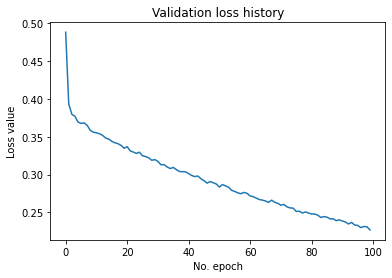

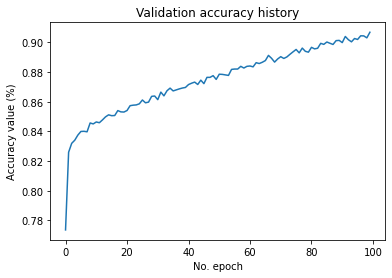

In [20]:
import matplotlib.pyplot as plt
# Visualize history
# Plot history: Validation loss
plt.plot(history.history['loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

4. Load the bing sentiment dictionary. Compute two separate embeddings for the negative and positive sentiments.

In [53]:
bing=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bing.csv')

In [59]:
bing_pos = bing[bing['sentiment']=='positive']
bing_neg = bing[bing['sentiment']=='negative']


In [62]:
corpus_gen_pos = [list(char) for char in bing_pos['word'].values]
corpus_gen_neg = [list(char) for char in bing_neg['word'].values]

In [64]:
#Initiate the models
model_pos = Word2Vec(bing_pos.word.values,size = 100, min_count=1)
model_neg = Word2Vec(bing_neg.word.values,size = 100, min_count=1)

In [69]:
# Document representation for the text
corpus_w2v_pos =[[model_pos.wv[word] for char in word if char in model_pos.wv.vocab.keys()] for word in corpus_gen_pos]
positive=[i for i in range(len(corpus_gen_pos)) if len(corpus_w2v_pos[i])>0]

corpus_w2v2_pos=[corpus_w2v_pos[i] for i in positive]

# Document average representation
corpus_w2v_avg_clean_pos=[sum(char)/len(char) for char in corpus_w2v2_pos]

# This corpus can be used later in clustering and classification tasks
print(corpus_w2v_avg_clean_pos[0])

[[-3.40077132e-02 -1.28055200e-01  2.82957722e-02 -1.38183823e-02
   2.42094826e-02 -2.09214106e-01  1.15990214e-01  3.60689797e-02
  -2.01982602e-01 -6.31567761e-02  7.25698993e-02  4.72864107e-04
   1.56391963e-01  3.13904256e-01  9.24515203e-02  1.16844513e-02
  -6.11483566e-02 -1.57065764e-01 -8.24768245e-02  2.14075997e-01
   2.25495026e-01 -1.51049793e-01  9.59328189e-02  2.24221841e-01
   8.26642588e-02 -6.79684505e-02 -8.29734728e-02 -7.53720477e-02
  -1.41120568e-01 -9.71632078e-02  4.49144877e-02  1.53797582e-01
  -3.19006234e-01 -4.45244508e-03  8.62747356e-02 -6.32092282e-02
   1.49828596e-02  9.68774930e-02  1.25062123e-01  4.27288003e-02
   2.28722438e-01  1.05741257e-02  1.04903482e-01 -3.94821204e-02
   6.71764240e-02 -1.40974626e-01 -1.21127507e-02  1.27272949e-01
   1.24393918e-01  3.37127335e-02  1.13457270e-01  1.32445013e-02
   1.96811572e-01 -2.73380995e-01 -2.49765832e-02  2.76954293e-01
   9.81691554e-02  4.61876243e-02  1.23850934e-01  6.11814074e-02
   7.65443

In [70]:
# Document representation for the text
corpus_w2v_neg =[[model_neg.wv[word] for char in word if char in model_neg.wv.vocab.keys()] for word in corpus_gen_neg]
positive=[i for i in range(len(corpus_gen_neg)) if len(corpus_w2v_neg[i])>0]

corpus_w2v2_neg=[corpus_w2v_neg[i] for i in positive]

# Document average representation
corpus_w2v_avg_clean_neg=[sum(char)/len(char) for char in corpus_w2v2_neg]

# This corpus can be used later in clustering and classification tasks
print(corpus_w2v_avg_clean_neg[0])

[[-1.12494000e-03 -2.69405860e-02  1.75909773e-02  4.52648848e-03
   1.13479625e-02 -1.43309403e-02  5.18551469e-03  2.62669870e-03
  -2.33001132e-02 -8.81574582e-03 -5.49490238e-03  1.09322520e-03
   1.62290465e-02  1.76630244e-02 -2.15395004e-03  6.00490253e-03
   5.08754654e-03 -2.18246970e-02 -1.11888042e-02  1.23374974e-02
   2.44373567e-02 -2.80620921e-02  1.99503843e-02  1.32283112e-02
   1.21538143e-03 -1.62248332e-02 -1.55737977e-02 -4.06116853e-03
  -9.96320602e-03 -1.29411239e-02  1.20704537e-02  1.82059016e-02
  -2.44697165e-02  9.02244879e-04  2.20975149e-02  3.94856138e-03
   4.79895994e-03  1.47108501e-02  1.71327237e-02 -5.47658419e-06
   1.53674260e-02  1.39608961e-02  1.24105448e-02 -6.81146653e-03
   9.96617507e-03 -2.01302227e-02 -2.93654995e-03  1.62106324e-02
   1.28056575e-02  9.89957061e-03  5.34063997e-03  2.59411219e-03
   1.95344780e-02 -2.81301569e-02 -4.00986383e-03  1.96244847e-02
   3.34235257e-03  7.49991043e-03  1.05079608e-02 -4.07653628e-03
   5.93114

5. Compute the similarity between these two vectors and a few selected reviews. Does it agree with their label?